In [7]:
import networkx as nx
import numpy as np

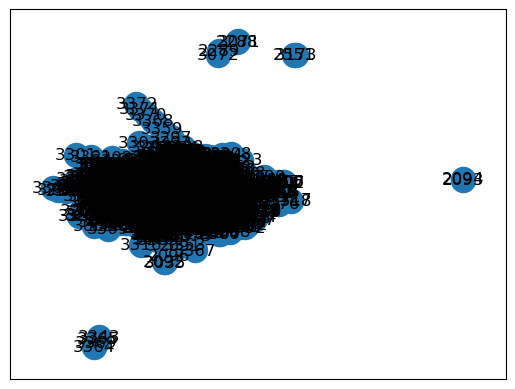

In [5]:
g = nx.read_graphml("airportsAndCoordAndPop.graphml")
nx.draw_networkx(g)

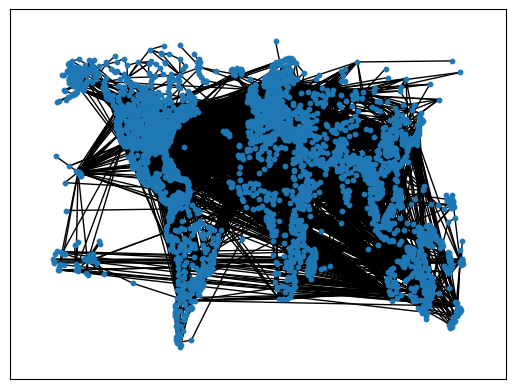

In [12]:
pos = {node: (float(g.nodes[node]['lon']), float(g.nodes[node]['lat'])) for node in g.nodes}
nx.draw_networkx(g, pos=pos, node_size=10, with_labels=False)